# Self labeled vs Pre-Trained labeled

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

Self-Labeled

In [ ]:
df = pd.read_csv('10_percent_of_comments.csv')
df.head()

,Timestamp,Comment,Tokenized_Comment,McDonald_Sentiment
0,10/22/2024 22:39,update e coli outbreak linked to mcdonalds qua...,update e coli outbreak linked to quarter pound...,Negative
1,10/23/2024 2:47,i just had it 3 hrs ago in northeast in app i ...,i just had it 3 hr ago in northeast in app i s...,Negative
2,10/22/2024 23:31,so many food outbreaks lately,so many food outbreak lately,Negative
3,10/24/2024 5:48,my husband was in the er yesterday likely from...,husband in the er yesterday likely from e coli...,Positive
4,10/23/2024 0:29,i ate a quarter pounder today while scrolling ...,i ate a quarter pounder while scrolling reddit...,Negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Timestamp           523 non-null    object
 1   Comment             523 non-null    object
 2   Tokenized_Comment   523 non-null    object
 3   McDonald_Sentiment  523 non-null    object
dtypes: object(4)
memory usage: 16.5+ KB


In [ ]:
df = df.drop(columns=['Comment', 'Timestamp'])
df.head()

,Tokenized_Comment,McDonald_Sentiment
0,update e coli outbreak linked to quarter pound...,Negative
1,i just had it 3 hr ago in northeast in app i s...,Negative
2,so many food outbreak lately,Negative
3,husband in the er yesterday likely from e coli...,Positive
4,i ate a quarter pounder while scrolling reddit...,Negative


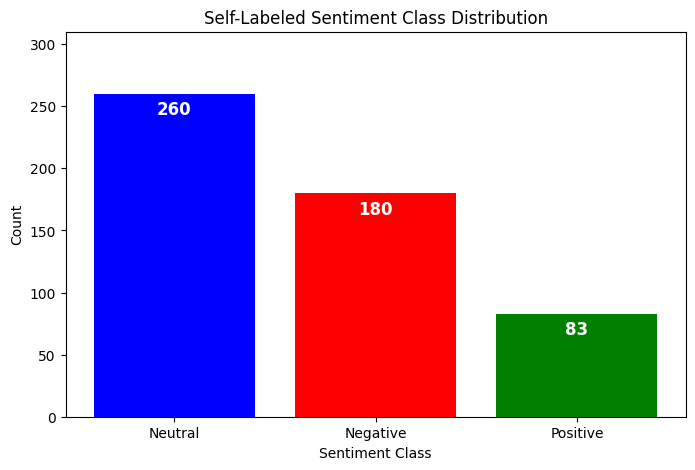

In [ ]:
sentiment_counts = df['McDonald_Sentiment'].value_counts()

color_mapping = {'Neutral': 'blue', 'Negative': 'red', 'Positive': 'green'}


plt.figure(figsize=(8, 5))
bars = plt.bar(sentiment_counts.index,
               sentiment_counts.values,
               color=[color_mapping[s] for s in sentiment_counts.index])


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height - 20,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=12, color='white', fontweight='bold')


plt.title('Self-Labeled Sentiment Class Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.ylim(0, max(sentiment_counts.values) + 50)

plt.show()

In [ ]:
df2 = pd.read_csv("filtered_data.csv")

# Load pre-trained RoBERTa model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to get sentiment using RoBERTa
def get_roberta_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return "Neutral"

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)


    logits = outputs.logits
    sentiment_class = torch.argmax(logits).item()

    # Map labels to sentiment
    sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_labels[sentiment_class]

# Apply sentiment analysis to the "Comment" column
df2["RoBERTa_Sentiment"] = df2["Comment"].apply(get_roberta_sentiment)

df2.to_csv("filtered_data_with_sentiment.csv", index=False)

print("Sentiment analysis completed! The results are saved in 'filtered_data_with_sentiment.csv'.")


Sentiment analysis completed! The results are saved in 'filtered_data_with_sentiment.csv'.


In [ ]:
df2 = pd.read_csv("filtered_data_with_sentiment.csv")
df2.head()

,Timestamp,Comment,Tokenized_Comment,RoBERTa_Sentiment
0,2024-10-22 22:39:00,update e coli outbreak linked to mcdonalds qua...,update e coli outbreak linked to quarter pound...,Negative
1,2024-10-23 02:47:00,i just had it 3 hrs ago in northeast in app i ...,i just had it 3 hr ago in northeast in app i s...,Negative
2,2024-10-22 23:31:00,so many food outbreaks lately,so many food outbreak lately,Negative
3,2024-10-24 05:48:00,my husband was in the er yesterday likely from...,husband in the er yesterday likely from e coli...,Positive
4,2024-10-23 00:29:00,i ate a quarter pounder today while scrolling ...,i ate a quarter pounder while scrolling reddit...,Negative


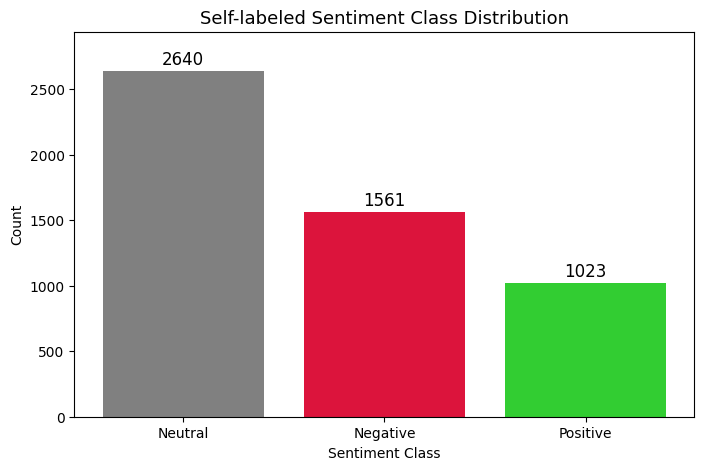

In [ ]:
val_count = df2['RoBERTa_Sentiment'].value_counts()
custom_colors = ['#808080', '#DC143C', '#32CD32']

plt.figure(figsize=(8, 5))
bars = plt.bar(val_count.index, val_count.values, color=custom_colors)

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 50,
        str(bar.get_height()),
        ha='center',
        fontsize=12,
        color='black'
    )

plt.title("Self-labeled Sentiment Class Distribution", fontsize=13)
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.ylim(0, max(val_count.values) + 300)

plt.show()

#Trained Model

#1.Self-Labeled

Class Imbalance

In [ ]:
df = df[['Tokenized_Comment', 'McDonald_Sentiment']]

# Convert Sentiment Labels to Numeric Classes
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['sentiment_label'] = df['McDonald_Sentiment'].map(label_mapping)

vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000)
X = vectorizer.fit_transform(df['Tokenized_Comment'])
y = df['sentiment_label']

# Check Class Distribution Before Applying SMOTE
print("Original class distribution:", Counter(y))

Original class distribution: Counter({1: 260, 0: 180, 2: 83})


In [ ]:
# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check class distribution after SMOTE
new_class_distribution = Counter(y_resampled)

original_class_distribution = Counter(y)
original_class_distribution, new_class_distribution

(Counter({0: 180, 2: 83, 1: 260}), Counter({0: 260, 2: 260, 1: 260}))

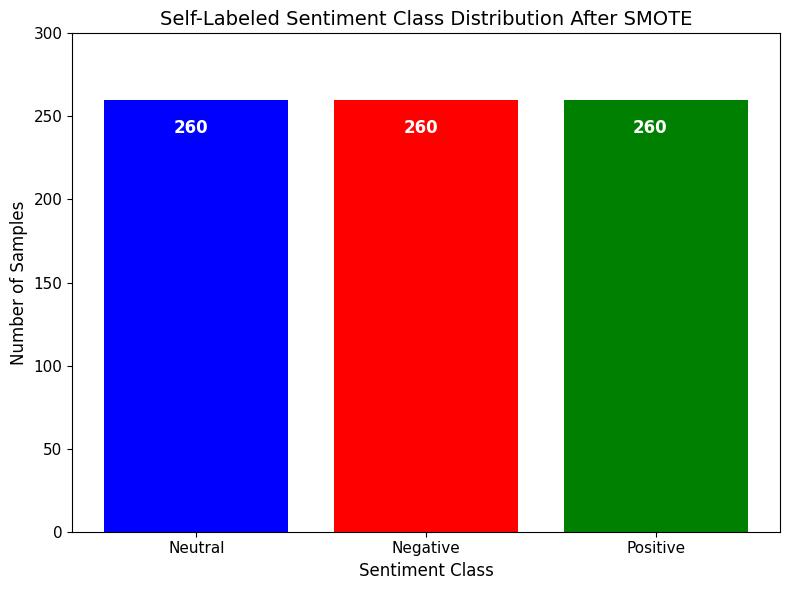

In [ ]:
# Count the class distribution after SMOTE
resampled_class_distribution = Counter(y_resampled)

# Define class order
ordered_classes = [1, 0, 2]
ordered_labels = ['Neutral', 'Negative', 'Positive']
ordered_colors = ['blue', 'red', 'green']

ordered_values = [resampled_class_distribution.get(cls, 0) for cls in ordered_classes]

plt.figure(figsize=(8, 6))
bars = plt.bar(ordered_labels, ordered_values, color=ordered_colors)

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2 - 0.1,
        bar.get_height() - 20,
        str(bar.get_height()),
        fontsize=12,
        color='white',
        fontweight='bold'
    )

plt.xlabel("Sentiment Class", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title("Self-Labeled Sentiment Class Distribution After SMOTE", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0, max(ordered_values) + 40)


plt.tight_layout()
plt.show()


In [ ]:
df.head()

,Tokenized_Comment,McDonald_Sentiment,sentiment_label
0,update e coli outbreak linked to quarter pound...,Negative,0
1,i just had it 3 hr ago in northeast in app i s...,Negative,0
2,so many food outbreak lately,Negative,0
3,husband in the er yesterday likely from e coli...,Positive,2
4,i ate a quarter pounder while scrolling reddit...,Negative,0


Self Train

In [ ]:
# Separating the 60% data for training data and 40% for testing data
trainsize = 0.6
X = df['Tokenized_Comment']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1-trainsize,
                                         random_state=123)

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000)

X_train_bow = vectorizer.fit_transform(X_train.astype(str))
X_test_bow = vectorizer.transform(X_test.astype(str))

X_train_bow = X_train_bow.toarray()
X_test_bow = X_test_bow.toarray()

Training Accuracy: 0.9904153354632588
Test Accuracy: 0.48095238095238096
[[27 42  1]
 [36 71  3]
 [14 13  3]]


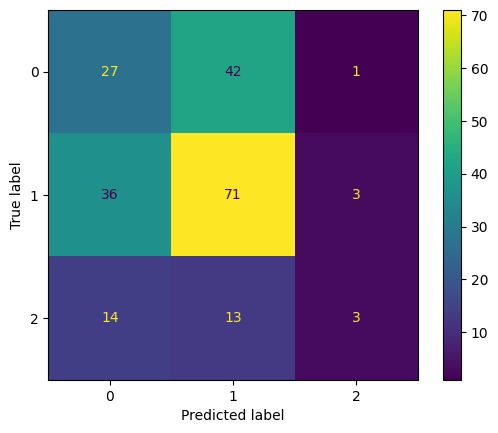

In [ ]:
# Train Naïve Bayes model
model_NB = MultinomialNB()
model_NB.fit(X_train_bow, y_train)

# Predict on test data
y_pred = model_NB.predict(X_test_bow)

# Evaluate performance
print("Training Accuracy:", model_NB.score(X_train_bow, y_train))
print("Test Accuracy:", model_NB.score(X_test_bow, y_test))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Training Accuracy: 0.9936102236421726
Test Accuracy: 0.5666666666666667
[[24 44  2]
 [17 92  1]
 [ 8 19  3]]


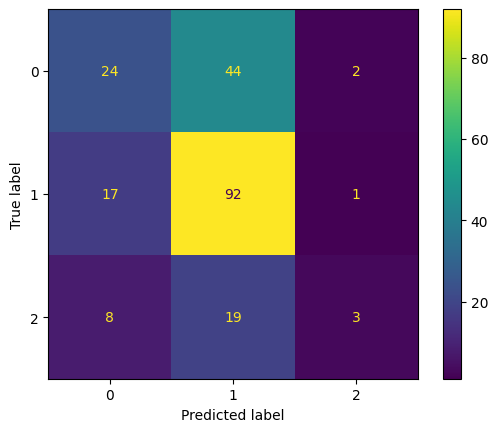

In [ ]:
# Train Logistic Regression model
model_LR = LogisticRegression(max_iter=10000)
model_LR.fit(X_train_bow, y_train)

# Predict on test data
y_pred = model_LR.predict(X_test_bow)

# Evaluate performance
print("Training Accuracy:", model_LR.score(X_train_bow, y_train))
print("Test Accuracy:", model_LR.score(X_test_bow, y_test))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Pre Trained

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Test Accuracy: 0.7619047619047619
[[50 20  0]
 [11 97  2]
 [ 1 16 13]]


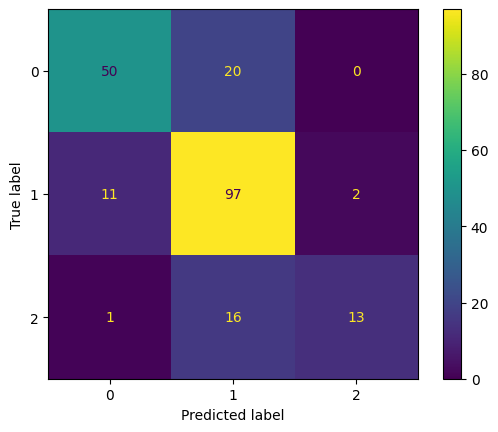

In [ ]:
# Load fine-tuned BERTweet model
model_name = "finiteautomata/bertweet-base-sentiment-analysis"  # or your fine-tuned one
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Ensure model is in eval mode
model.eval()

# Function to classify sentiment using BERTweet
def classify_sentiment_bertweet(text):
    if pd.isna(text) or text.strip() == "":
        return 1

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    pred_class = torch.argmax(outputs.logits, dim=1).item()
    return pred_class

y_pred = X_test.apply(classify_sentiment_bertweet)

# Evaluate performance
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#2.RoBERTa Labeled

Class Imbalance

In [ ]:
df2 = df2[['Tokenized_Comment', 'RoBERTa_Sentiment']]

label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df2['sentiment_label'] = df2['RoBERTa_Sentiment'].map(label_mapping)

vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000)
X = vectorizer.fit_transform(df2['Tokenized_Comment'])
y = df2['sentiment_label']

print("Original class distribution:", Counter(y))

<ipython-input-18-9b5668388951>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['sentiment_label'] = df2['RoBERTa_Sentiment'].map(label_mapping)


Original class distribution: Counter({1: 2640, 0: 1561, 2: 1023})


In [ ]:
# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check class distribution after SMOTE
new_class_distribution = Counter(y_resampled)

# Assign Counter(y) to original_class_distribution
original_class_distribution = Counter(y)

original_class_distribution, new_class_distribution

(Counter({0: 1561, 2: 1023, 1: 2640}), Counter({0: 2640, 2: 2640, 1: 2640}))

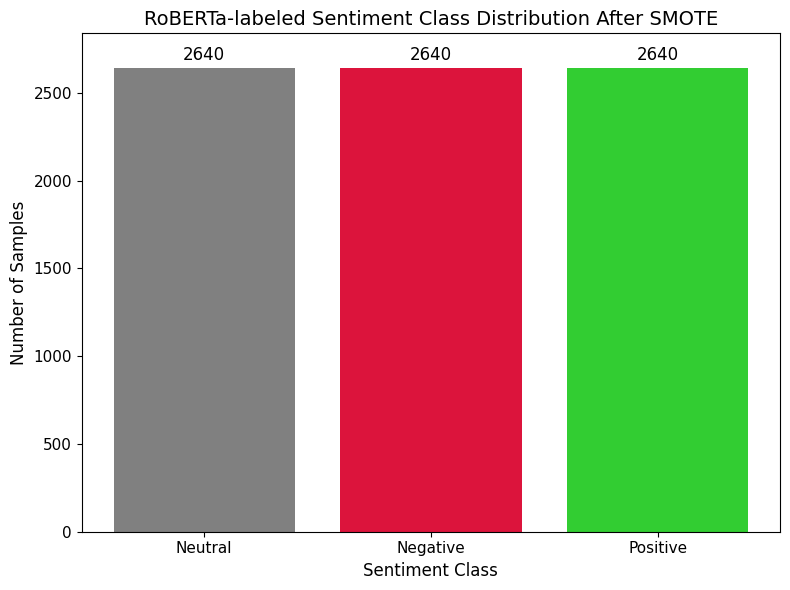

In [ ]:
resampled_class_distribution = Counter(y_resampled)

ordered_classes = [0, 1, 2]
ordered_labels = ['Neutral', 'Negative', 'Positive']
ordered_colors = ['#808080', '#DC143C', '#32CD32']

ordered_values = [resampled_class_distribution.get(cls, 0) for cls in ordered_classes]

plt.figure(figsize=(8, 6))
bars = plt.bar(ordered_labels, ordered_values, color=ordered_colors)

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 50,
        str(bar.get_height()),
        ha='center',
        fontsize=12,
        color='black'
    )

plt.xlabel("Sentiment Class", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title("RoBERTa-labeled Sentiment Class Distribution After SMOTE", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0, max(ordered_values) + 200)

plt.tight_layout()
plt.show()



In [ ]:
# Separating the 60% data for training and 40% for testing data
trainsize = 0.6
X = df2['Tokenized_Comment']
y = df2['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-trainsize, random_state=123)


In [ ]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000)

# Tokenize and transform training & testing data
X_train_bow = vectorizer.fit_transform(X_train.astype(str))
X_test_bow = vectorizer.transform(X_test.astype(str))

X_train_bow = X_train_bow.toarray()
X_test_bow = X_test_bow.toarray()

Training Accuracy: 0.9001276324186344
Test Accuracy: 0.5933014354066986
[[330 220  23]
 [246 790  52]
 [102 207 120]]


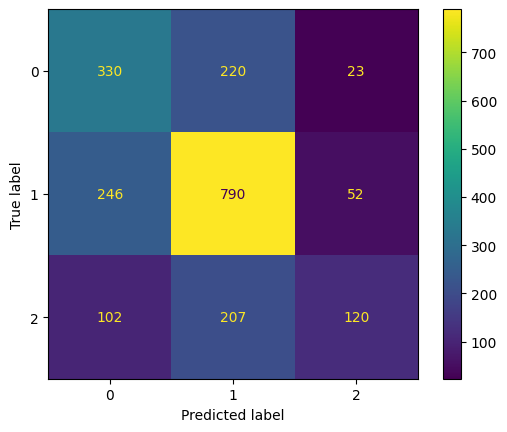

In [ ]:
# Train Naïve Bayes model
model_NB = MultinomialNB()
model_NB.fit(X_train_bow, y_train)

# Predict on test data
y_pred = model_NB.predict(X_test_bow)

# Evaluate performance
print("Training Accuracy:", model_NB.score(X_train_bow, y_train))
print("Test Accuracy:", model_NB.score(X_test_bow, y_test))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Training Accuracy: 0.9744735162731334
Test Accuracy: 0.6133971291866028
[[270 265  38]
 [171 855  62]
 [ 86 186 157]]


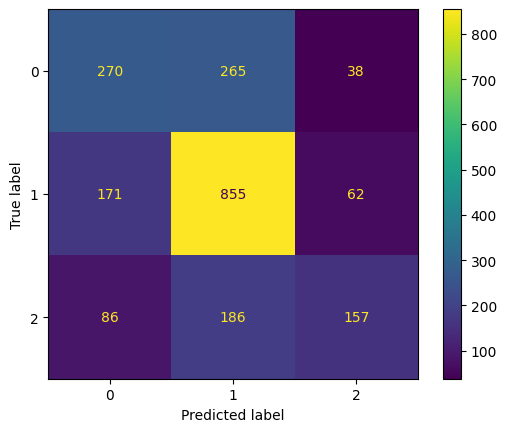

In [ ]:
# Train Logistic Regression model
model_LR = LogisticRegression(max_iter=10000)
model_LR.fit(X_train_bow, y_train)

# Predict on test data
y_pred = model_LR.predict(X_test_bow)

# Evaluate performance
print("Training Accuracy:", model_LR.score(X_train_bow, y_train))
print("Test Accuracy:", model_LR.score(X_test_bow, y_test))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#Bertweet

Pre-trained

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Test Accuracy: 0.7588516746411483
[[384 181   8]
 [ 75 984  29]
 [ 20 191 218]]


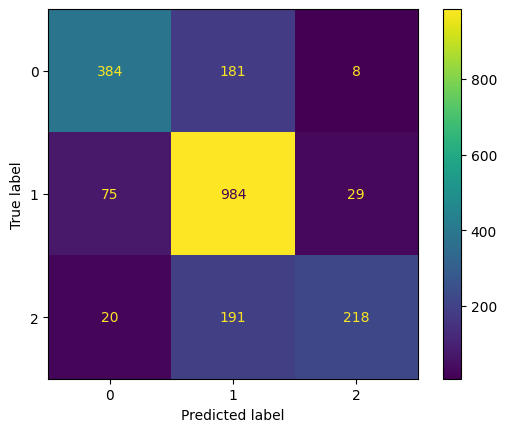

In [ ]:
# Load fine-tuned BERTweet model
model_name = "finiteautomata/bertweet-base-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Ensure model is in eval mode
model.eval()

# Function to classify sentiment using BERTweet
def classify_sentiment_bertweet(text):
    if pd.isna(text) or text.strip() == "":
        return 1

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    pred_class = torch.argmax(outputs.logits, dim=1).item()
    return pred_class


y_pred = X_test.apply(classify_sentiment_bertweet)

# Evaluate performance
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#Word Cloud

Positive Word

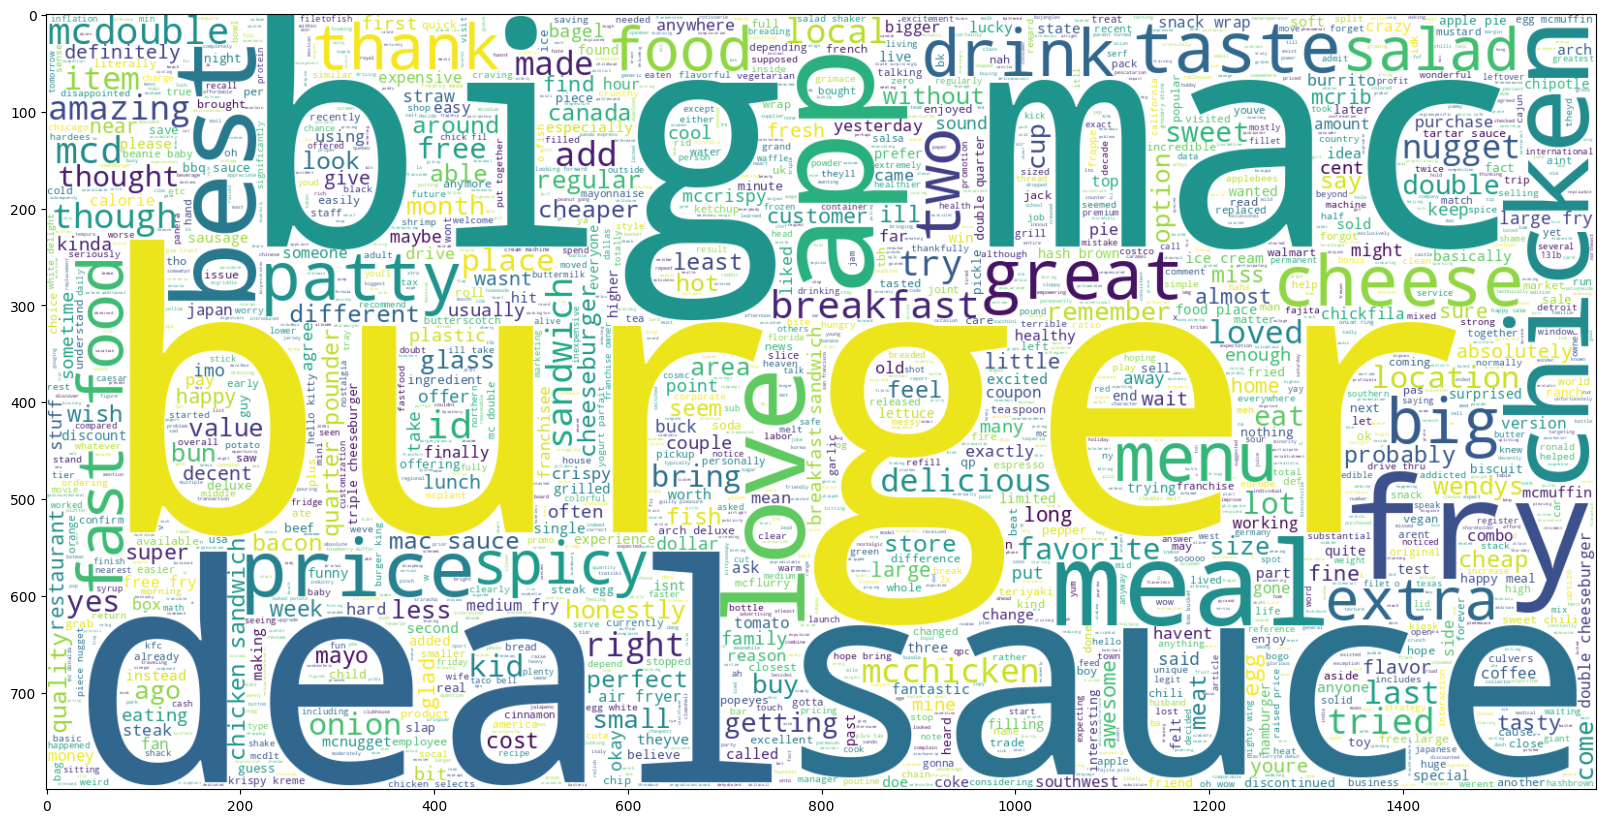

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(background_color = 'white',max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df2[df2.RoBERTa_Sentiment == 'Positive'].Tokenized_Comment))
plt.imshow(wc , interpolation = 'bilinear')

Negative Word

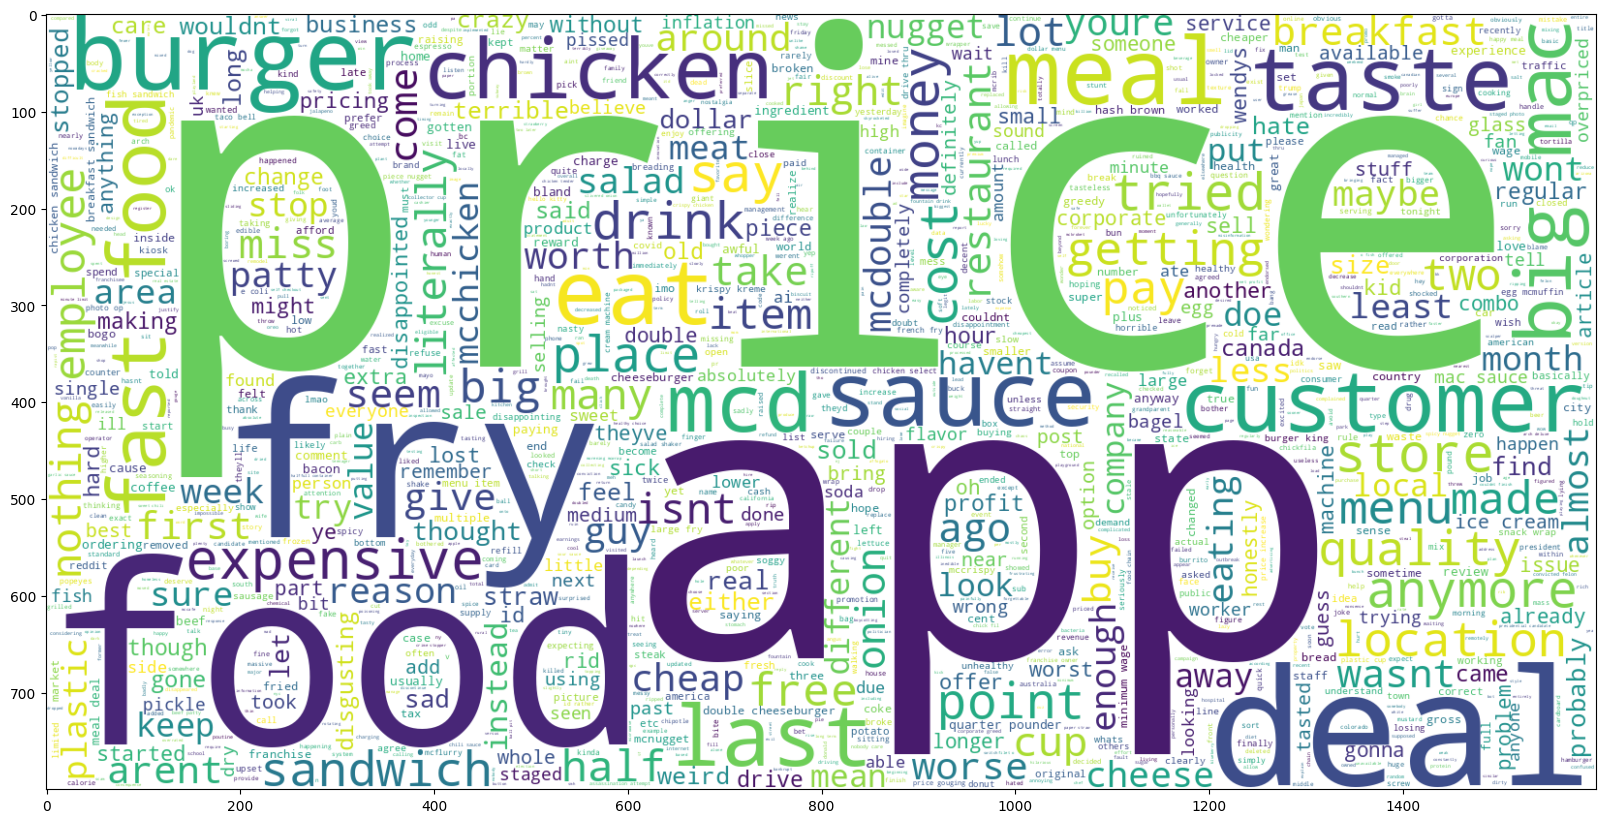

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(background_color = 'white',max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df2[df2.RoBERTa_Sentiment == 'Negative'].Tokenized_Comment))
plt.imshow(wc , interpolation = 'bilinear')